# Multi-Class Classification of Chest X-Ray Images Using CNN: A DL approach for Accurate Diagnosis of COVID-19 and Other Viral Infections

# Importing Necessary Libraries

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
for dirpath,dirnames,filenames in os.walk("C:/Users/bysan/Downloads/Covid19/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 1 images in 'C:/Users/bysan/Downloads/Covid19/COVID_IEEE'.
there are 0 directories and 536 images in 'C:/Users/bysan/Downloads/Covid19/COVID_IEEE\covid'.
there are 0 directories and 668 images in 'C:/Users/bysan/Downloads/Covid19/COVID_IEEE\normal'.
there are 0 directories and 619 images in 'C:/Users/bysan/Downloads/Covid19/COVID_IEEE\virus'.


In [3]:
data_dir = pathlib.Path("C:/Users/bysan/Downloads/Covid19/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names


array(['covid', 'covid.zip', 'normal', 'virus'], dtype='<U9')

In [4]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")

    return img

['person1657_virus_2864.jpeg']
image shape (1288, 1624)


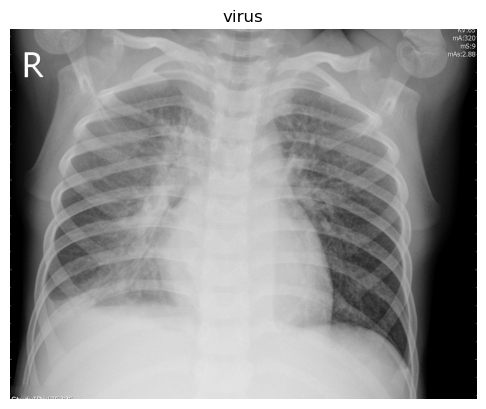

In [5]:
img = view_image("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/","virus")

['NORMAL2-IM-0719-0001.jpeg']
image shape (1408, 1616)


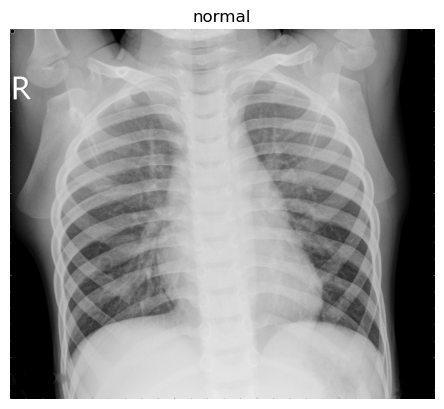

In [6]:
img = view_image("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/","normal")

['6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg']
image shape (998, 1279, 3)


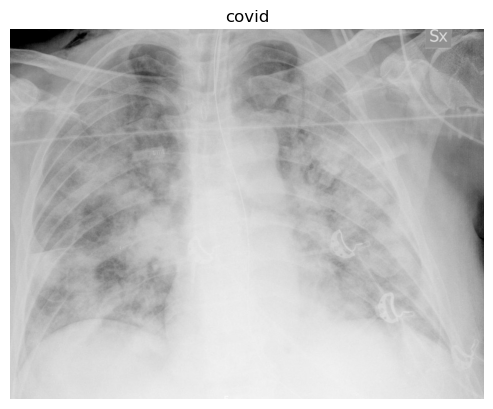

In [7]:
img = view_image("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/","covid")

# Data Loading & Feature Extraction

In [8]:
data=[]
labels=[]
covid=os.listdir("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/covid/")
for a in covid:

    image = cv2.imread("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/covid/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [9]:
normal=os.listdir("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/normal/")
for a in normal:

    image = cv2.imread("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/normal/"+a,)
    image = cv2.resize(image, (224, 224))



    data.append(image)
    labels.append(1)

In [10]:
virus=os.listdir("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/virus/")
for a in virus:

    image = cv2.imread("C:/Users/bysan/Downloads/Covid19/COVID_IEEE/virus/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(2)


In [11]:
data = np.array(data) / 255.0
img_labels = np.array(labels)

# Data Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, img_labels, test_size=0.20, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Model Fitting

# Pre-trained Model

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model without the top layer (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x) # Add a fully connected layer
predictions = Dense(3, activation='softmax')(x) # Add a final softmax layer for classification

# Construct the final model
model_res = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now the model is ready to be trained on your dataset
model_res.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
model_res.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.3757 - loss: 1.5348 - val_accuracy: 0.6507 - val_loss: 0.9760
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6060 - loss: 0.9531 - val_accuracy: 0.5731 - val_loss: 0.8859
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.6448 - loss: 0.8402 - val_accuracy: 0.7626 - val_loss: 0.7559
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.6711 - loss: 0.7692 - val_accuracy: 0.5639 - val_loss: 0.8681
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6788 - loss: 0.7257 - val_accuracy: 0.7100 - val_loss: 0.6789
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7494 - loss: 0.6699 - val_accuracy: 0.6712 - val_loss: 0.6752
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.6976 - loss: 0.6792 - val_accuracy: 0.7877 - val_loss: 0.6084
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7178 - loss: 0.6804 - val_accuracy: 0.7671 - va

Text(0.5, 1.0, 'Training-Validation Accuracy')

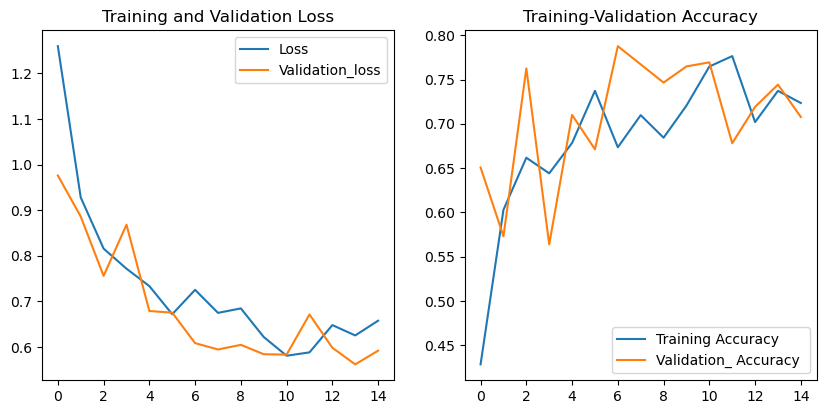

In [15]:
#saving the model history
loss = pd.DataFrame(model_res.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [16]:
predictions = model_res.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


In [17]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       108
           1       0.63      0.97      0.76       129
           2       0.92      0.28      0.43       128

    accuracy                           0.71       365
   macro avg       0.78      0.72      0.68       365
weighted avg       0.78      0.71      0.67       365



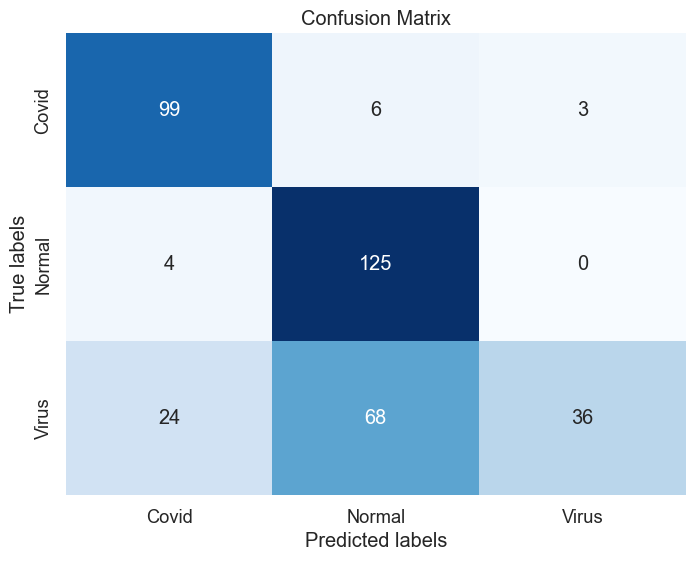

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test_new are already defined
conf_matrix = confusion_matrix(y_test_new, y_pred)

# Define class labels
class_names = ['Covid', 'Normal', 'Virus']  

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

## Custom CNN

In [23]:
from keras.layers import MaxPooling2D

model2 = Sequential()

# Block 1
model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Block 2
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Block 3
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Block 4
model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

# Fully Connected Layers
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

# Compile the model2
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\bysan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model2.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 324s 10s/step - accuracy: 0.5100 - loss: 45.6002 - val_accuracy: 0.2671 - val_loss: 5.1291
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 315s 10s/step - accuracy: 0.6908 - loss: 3.6672 - val_accuracy: 0.2671 - val_loss: 4.2959
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.7523 - loss: 1.3032 - val_accuracy: 0.2671 - val_loss: 2.4268
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 311s 10s/step - accuracy: 0.8221 - loss: 0.6664 - val_accuracy: 0.2671 - val_loss: 2.0938
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 309s 10s/step - accuracy: 0.8239 - loss: 0.5166 - val_accuracy: 0.2671 - val_loss: 2.1782
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 306s 10s/step - accuracy: 0.8692 - loss: 0.3664 - val_accuracy: 0.2671 - val_loss: 2.3538
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.8896 - loss: 0.3446 - val_accuracy: 0.2671 - val_loss: 2.2200
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 314s 10s/step - accuracy: 0.8851 - loss: 0.3033 - val_accuracy: 0

Text(0.5, 1.0, 'Training-Validation Accuracy')

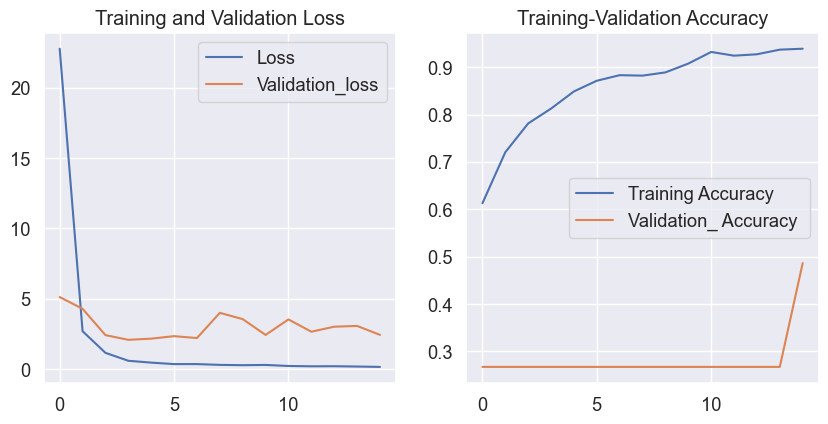

In [25]:
#saving the model history
loss = pd.DataFrame(model2.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [26]:
predictions = model2.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


In [27]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.97      0.65       108
           1       0.00      0.00      0.00       129
           2       0.45      0.52      0.49       128

    accuracy                           0.47       365
   macro avg       0.31      0.50      0.38       365
weighted avg       0.30      0.47      0.36       365



C:\Users\bysan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bysan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bysan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


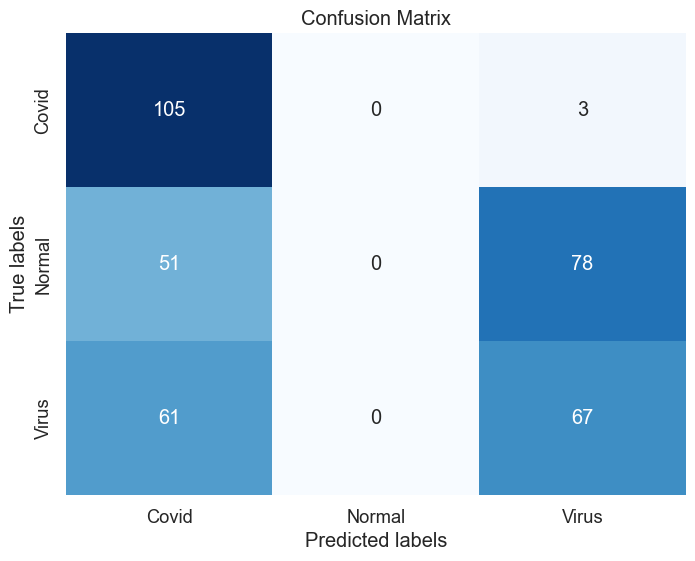

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test_new are already defined
conf_matrix = confusion_matrix(y_test_new, y_pred)

# Define class labels
class_names = ['Covid', 'Normal', 'Virus']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

# Model Enhancement

In [29]:
model3 = Sequential()

#Block Number 1
model3.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))

model3.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))

model3.add(MaxPool2D((2,2)))

#Block Number 2
model3.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))


model3.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))

model3.add(MaxPool2D((2,2)))

#Block Number 3
model3.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))

model3.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model3.add(Activation("relu"))

model3.add(MaxPool2D((2,2)))

model3.add(MaxPool2D((2,2)))

# Fully Connected layer
model3.add(Flatten())

model3.add(Dense(units=1024, activation="relu"))

model3.add(Dense(units=256, activation="relu"))


model3.add(Dense(units=3, activation="softmax"))

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\bysan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [30]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,241,315 (100.10 MB)

 Trainable params: 26,241,315 (100.10 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model3.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.4904 - loss: 1.0588 - val_accuracy: 0.7808 - val_loss: 0.6527
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.8418 - loss: 0.4769 - val_accuracy: 0.8973 - val_loss: 0.2729
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.9117 - loss: 0.2617 - val_accuracy: 0.9087 - val_loss: 0.2510
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.9427 - loss: 0.1899 - val_accuracy: 0.9064 - val_loss: 0.2525
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - accuracy: 0.9588 - loss: 0.1386 - val_accuracy: 0.9155 - val_loss: 0.2374
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.9562 - loss: 0.1049 - val_accuracy: 0.8995 - val_loss: 0.2622
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.9652 - loss: 0.0941 - val_accuracy: 0.9110 - val_loss: 0.2955
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.9646 - loss: 0.1004 - val_accuracy: 0.8950 - v

### Model Evaluation Metrics

Text(0.5, 1.0, 'Training-Validation Accuracy')

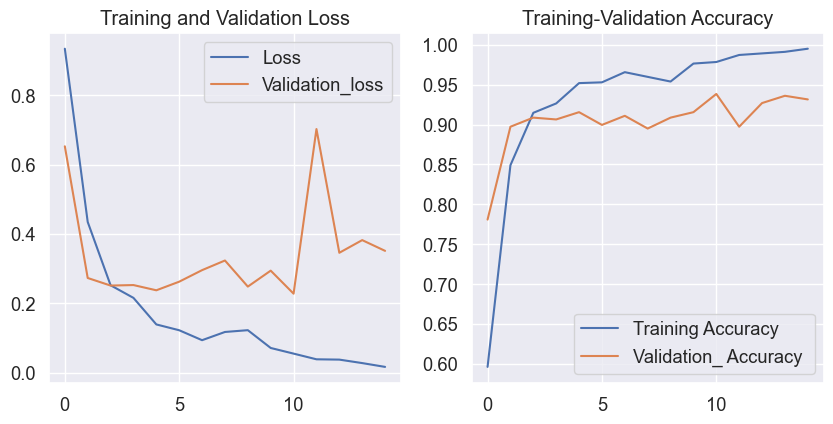

In [32]:
#saving the model history
loss = pd.DataFrame(model3.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [33]:
predictions = model3.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


In [34]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       108
           1       0.94      0.91      0.93       129
           2       0.90      0.94      0.92       128

    accuracy                           0.93       365
   macro avg       0.94      0.94      0.94       365
weighted avg       0.94      0.93      0.93       365



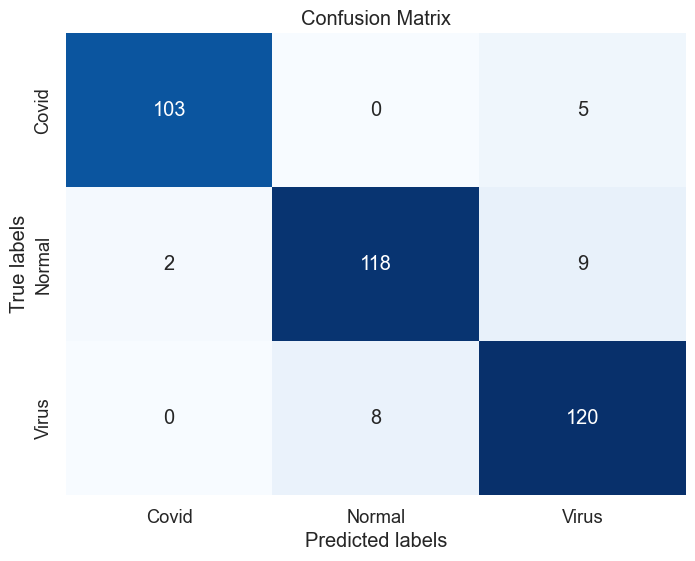

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test_new are already defined
conf_matrix = confusion_matrix(y_test_new, y_pred)

# Define class labels
class_names = ['Covid', 'Normal', 'Virus']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

,covid,normal,virus
covid,104,0,4
normal,8,114,7
virus,2,9,117
